## **Соревнования с Kaggle**

https://www.kaggle.com/competitions/aith-dl-competition-text-data

Посылки оцениваются по метрике **ROC AUC**.




In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset
import torch

### Загрузка данных 

In [2]:
# Загрузка данных
train_data = pd.read_csv("../data/kaggle_dataset_text/train.csv")
test_data = pd.read_csv("../data/kaggle_dataset_text/test.csv")

# Просмотр первых строк данных
display(train_data.head())
display(test_data.head())

,id,text,score
0,127857,пидорасы наше правительство издеваються над пе...,1
1,86622,чё цена?,0
2,33294,старый пиндосовский прихвостень...,1
3,421,хорошо потрудились... молодец!!!,0
4,118550,хаба это скучная возня по полу👎,0


,id,text
0,152591,"господь услышал слова людей, наши молитвы дошл..."
1,108771,их тоже надо выстрелами в головы пристрелить.б...
2,198853,"не ужели не понятно, он так завтракает, обедае..."
3,194736,"я открыла, прочитала"
4,88110,нет ты давай по взрослому с помадой :p :d


In [3]:
# размер датаесета
print(train_data.shape) 
print(test_data.shape)

(173803, 3)
(74487, 2)


слишком большой датасет... буду обучать на более мелкой выборке

### Визуализация данных

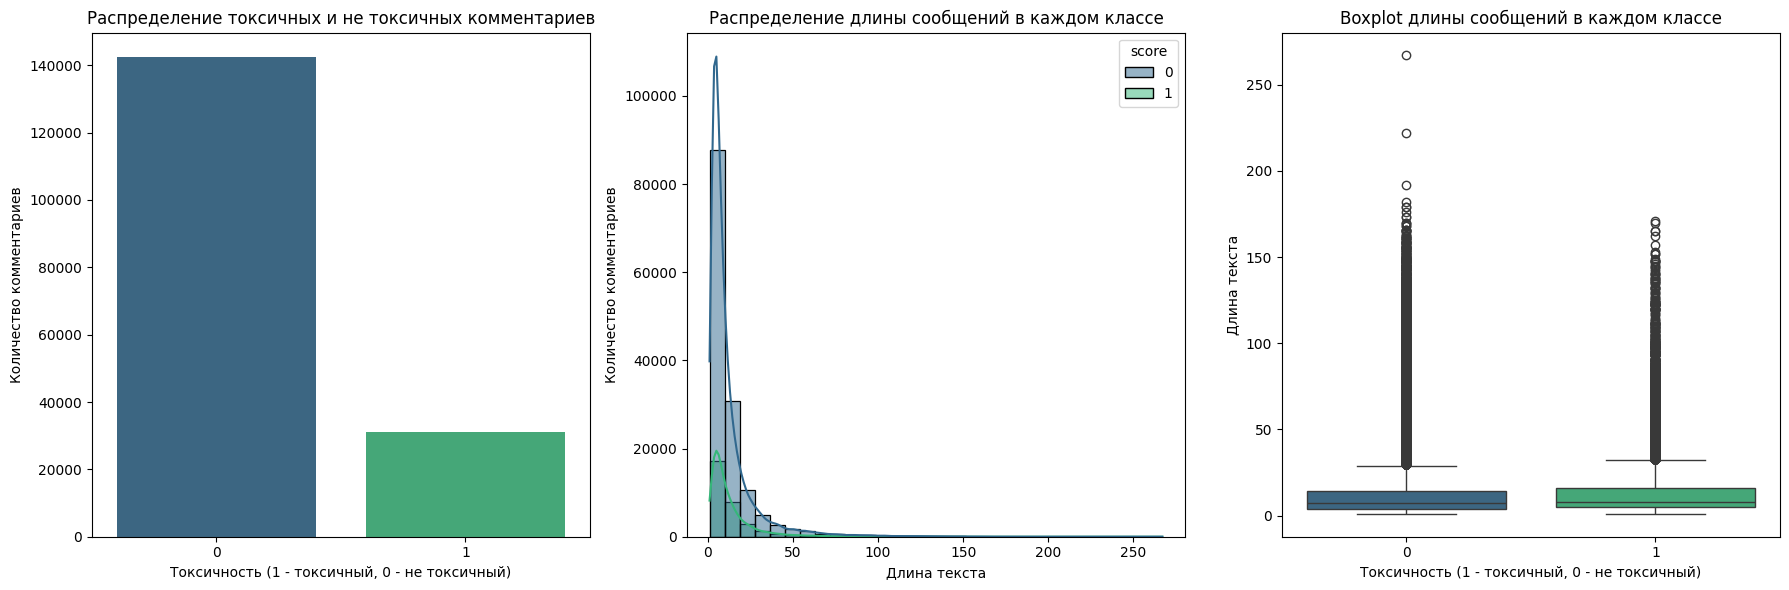

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Подсчет количества токсичных и не токсичных комментариев
toxicity_counts = train_data['score'].value_counts()

# Визуализация распределения токсичных и не токсичных комментариев
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.barplot(x=toxicity_counts.index, y=toxicity_counts.values, hue=toxicity_counts.index, palette="viridis", legend=False)
plt.title('Распределение токсичных и не токсичных комментариев')
plt.xlabel('Токсичность (1 - токсичный, 0 - не токсичный)')
plt.ylabel('Количество комментариев')

# Добавление столбца с длиной текста в словах
train_data['text_length'] = train_data['text'].apply(lambda x: len(x.split()))

# Визуализация распределения длины текста для каждого класса
plt.subplot(1, 3, 2)
sns.histplot(data=train_data, x='text_length', hue='score', kde=True, palette="viridis", bins=30)
plt.title('Распределение длины сообщений в каждом классе')
plt.xlabel('Длина текста')
plt.ylabel('Количество комментариев')

# Boxplot для длины сообщений в каждом классе
plt.subplot(1, 3, 3)
sns.boxplot(data=train_data, x='score', y='text_length', palette="viridis", hue='score', legend=False)
plt.title('Boxplot длины сообщений в каждом классе')
plt.xlabel('Токсичность (1 - токсичный, 0 - не токсичный)')
plt.ylabel('Длина текста')

plt.tight_layout()
plt.show()

### Предобработка данных
Стоит убрать эмодзи, нечитаемые символы ﻿, стоит удалить и сайты, номера телефонов

In [5]:
import re
import emoji

def clean_text(text):
    # Удаление эмодзи (или замена на текстовое описание)
    text = emoji.demojize(text, delimiters=(" ", " "))          # Замена эмодзи на текст
    text = re.sub(r":[a-zA-Z_]+:", " ", text)                   # Удаление текстового описания эмодзи
    # Удаление английских слов (например, thumbs down, red exclamation mark)
    text = re.sub(r"\b[a-zA-Z]+\b", " ", text)                  # Удаление всех английских слов

    # Удаление номеров телефонов (все возможные форматы)
    phone_patterns = [
        r"\b\d{11}\b",  # 89138609898
        r"\b\d{1}\s?\(\d{3}\)\s?\d{3}-\d{2}-\d{2}\b",       # 8 (913) 860-98-98
        r"\b\+\d{1}\s?\d{3}\s?\d{3}\s?\d{2}\s?\d{2}\b",     # +7 913 860 98 98
        r"\b\d{3}-\d{3}-\d{2}-\d{2}\b",                     # 913-860-98-98
        r"\b\d{1}-\d{3}-\d{3}-\d{2}-\d{2}\b",               # 8-913-860-98-98
        r"\b\+\d{1}\d{10}\b",                               # +79138609898
        r"\b\+\d{1}\(\d{3}\)\d{3}-\d{2}-\d{2}\b",           # +7(913)860-98-98
        r"\b\d{1}\s\d{3}\s\d{3}\s\d{2}\s\d{2}\b",           # 8 913 860 98 98
    ]
    for pattern in phone_patterns:
        text = re.sub(pattern, "[PHONE]", text)

    # Удаление адресов (пример для улиц)
    text = re.sub(r"\bул\.\s*\w+\s*\d+\w*\b", "[ADDRESS]", text)

    # Удаление ссылок на сайты
    text = re.sub(r"https?://\S+|www\.\S+", "[URL]", text)

    # Удаление спецсимволов и пунктуации (кроме букв, цифр и пробелов)
    text = re.sub(r"[^a-zA-Zа-яА-ЯёЁ0-9\s]", " ", text)

    # Удаление лишних пробелов
    text = re.sub(r"\s+", " ", text).strip()

    # Приведение к нижнему регистру
    text = text.lower()

    return text


# Очистка комментариев
train_data["text"] = [clean_text(comment) for comment in train_data["text"]]
test_data["text"] = [clean_text(comment) for comment in test_data["text"]]

### Подготовка данных

In [6]:
# Ограничиваем размер данных для эксперимента
train_sample = train_data.sample(n=10000, random_state=42)      # 10,000 строк для обучения
val_sample = train_data.sample(n=10000, random_state=24)        # 10,000 строк для проверки

# Разделение на текст и метки
train_texts = train_sample['text'].tolist()
train_labels = train_sample['score'].tolist()

val_texts = val_sample['text'].tolist()
val_labels = val_sample['score'].tolist()

# Токенизация текстов
model_name = "s-nlp/russian_toxicity_classifier"  # Модель на основе RuBERT
tokenizer = BertTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Создание Dataset
class ToxicCommentsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ToxicCommentsDataset(train_encodings, train_labels)
val_dataset = ToxicCommentsDataset(val_encodings, val_labels)

### Модель от Сколково для классификации токсичных русских комментариев


In [7]:
# Проверка доступности CUDA
# Проверка доступности MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS доступен. Используем MPS.")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("MPS недоступен. Используем CUDA или CPU.")
print(f"Используемое устройство: {device}")

# Загрузка предобученной модели
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

MPS доступен. Используем MPS.
Используемое устройство: mps


In [8]:
# архитектура модели
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

### Обучение с TrainingArguments
более простое чем писать свой train / eval loop

In [10]:
# Настройка тренировочных аргументов
training_args = TrainingArguments(
    output_dir='../logs/toxic_comments_results',
    evaluation_strategy="steps",  # Оценка по шагам
    eval_steps=500,               # Частота оценки (каждые 100 шагов)
    save_strategy="steps",        # Сохранение модели по шагам
    save_steps=500,               # Частота сохранения модели
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    logging_dir='../logs/toxic_comments',
    save_total_limit=1,
    metric_for_best_model="roc_auc",
    load_best_model_at_end=True,
)

# Функция для вычисления метрики ROC AUC
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'roc_auc': roc_auc_score(p.label_ids, preds)}

# Создание Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  
)

# Дообучение модели
trainer.train()

/Users/anastasia/docs/ITMO/DL_Course/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: katimanova (katimanova-itmo-university). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss,Roc Auc
500,0.060100,0.063122,0.974026
1000,0.030900,0.080685,0.976642
1500,0.006100,0.095736,0.974091


TrainOutput(global_step=1875, training_loss=0.026236364428202312, metrics={'train_runtime': 1260.4479, 'train_samples_per_second': 23.801, 'train_steps_per_second': 1.488, 'total_flos': 1973332915200000.0, 'train_loss': 0.026236364428202312, 'epoch': 3.0})

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [11]:
# Оценка модели на валидационной выборке
results = trainer.evaluate()
print(f"ROC AUC на валидационной выборке: {results['eval_roc_auc']}")

ROC AUC на валидационной выборке: 0.9766416106141289


### Тестовое предсказание

In [13]:
# Предсказание на тестовой выборке
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True, max_length=128)
test_dataset = ToxicCommentsDataset(test_encodings, [0] * len(test_data))

predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

# Сохранение результатов в файл
submission = pd.DataFrame({'id': test_data['id'], 'score': probs})
submission.to_csv('../output/submission.csv', index=False)
print("Результаты сохранены в ../output/submission.csv")

/Users/anastasia/docs/ITMO/DL_Course/.venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Результаты сохранены в ../output/submission.csv


### Выводы
Как оказалось, чем меньше стараешься - тем лучше ...  
Без предобработки текста результат вырос.

Вот результат с предобработкой на 3 эпохи - переобучение:

| Epoch | Training Loss | Validation Loss | Roc Auc   |
|-------|---------------|-----------------|-----------|
| 1     | 0.060800      | 0.061997        | 0.980437  |
| 2     | 0.029500      | 0.087455        | 0.975275  |
| 3     | 0.008100      | 0.102071        | 0.974634  |

**ROC AUC на валидационной выборке:** `0.9804369879768553`

Вот результат с другой обработкой на 3 эпохи - переобучение но получше:

| Epoch | Training Loss | Validation Loss | Roc Auc   |
|-------|---------------|-----------------|-----------|
| 1     | 0.060100     | 0.063122        | 0.974026  |
| 2     | 0.030900     | 0.080685       | 0.976642 |
| 3     | 0.006100     | 0.095736        | 0.974091 |

**ROC AUC на валидационной выборке:** `0.9766416106141289`

Без обработки текстовой:
пока лучший вариант - запускала его в коллабе 
